##### Ładowanie wszystkich wyników z 08.x, liczenie metryk, generowanie wizualizacji: TP/FP/FN, miniatury, tabele.


### 0. Importy, ścieżki i wczytanie danych

In [32]:
from pathlib import Path
import pandas as pd

"""
Notatnik porównujący wyniki detektorów.

Zadania:
- wczytać CSV z wynikami (detections_*.csv),
- opcjonalnie wczytać annotacje ground truth,
- policzyć metryki (precision, recall, mAP),
- wygenerować podstawowe statystyki.
"""

PROJECT_ROOT = Path.cwd().resolve()
EVAL_OUTPUT_DIR = PROJECT_ROOT / "outputs" / "detector_eval"

# Wyniki detektorów dostępne w tej chwili
paths = {
    "yolo_syrena_maluch": EVAL_OUTPUT_DIR / "detections_yolo_syrena_maluch.csv",
    # jeśli później dodasz inne modele, dopiszesz je tutaj, np.:
    # "yolo_coco": EVAL_OUTPUT_DIR / "detections_yolo.csv",
    # "lvis": EVAL_OUTPUT_DIR / "detections_lvis.csv",
    # "owl_vit": EVAL_OUTPUT_DIR / "detections_owl_vit.csv",
}

dfs = []
for model_name, path in paths.items():
    if path.exists():
        df = pd.read_csv(path)
        df["model"] = model_name  # ujednolicamy nazwę modelu
        dfs.append(df)

if dfs:
    df_det = pd.concat(dfs, ignore_index=True)
else:
    df_det = pd.DataFrame(columns=[
        "file_name", "model", "prompt", "class_raw", "class_norm",
        "score", "x_min", "y_min", "x_max", "y_max"
    ])

print("Łączna liczba detekcji:", len(df_det))
df_det.head()

Łączna liczba detekcji: 12


,file_name,model,prompt,class_raw,class_norm,score,x_min,y_min,x_max,y_max
0,000202.jpg,yolo_syrena_maluch,NaN,maluch,maluch,0.993050,149.058594,285.120636,981.426270,800.000000
1,000406.jpg,yolo_syrena_maluch,NaN,maluch,maluch,0.860069,63.353672,147.595215,778.293945,554.524597
2,000406.jpg,yolo_syrena_maluch,NaN,syrena,syrena,0.318448,67.720314,150.965698,786.232727,557.424133
3,485648612_1110701837764222_6372902184361778388...,yolo_syrena_maluch,NaN,maluch,maluch,0.766909,223.697678,174.087799,768.936829,584.548523
4,486445030_1111333564367716_8715312187251400072...,yolo_syrena_maluch,NaN,syrena,syrena,0.324370,126.420074,225.872665,734.756531,715.895325


In [42]:
"""
    Podstawowe statystyki dla modelu Syrena/Maluch.

    df_det – wszystkie detekcje z CSV.
"""

df_det_filt = df_det[~df_det["class_norm"].isna()].copy()
print("Detekcje po filtrze:", len(df_det_filt))
print("\nLiczba detekcji wg klasy:")
print(df_det_filt["class_norm"].value_counts())

print("\nLiczba obrazów z daną klasą:")
print(df_det_filt.groupby("class_norm")["file_name"].nunique())

Detekcje po filtrze: 12

Liczba detekcji wg klasy:
class_norm
maluch    7
syrena    5
Name: count, dtype: int64

Liczba obrazów z daną klasą:
class_norm
maluch    7
syrena    4
Name: file_name, dtype: int64


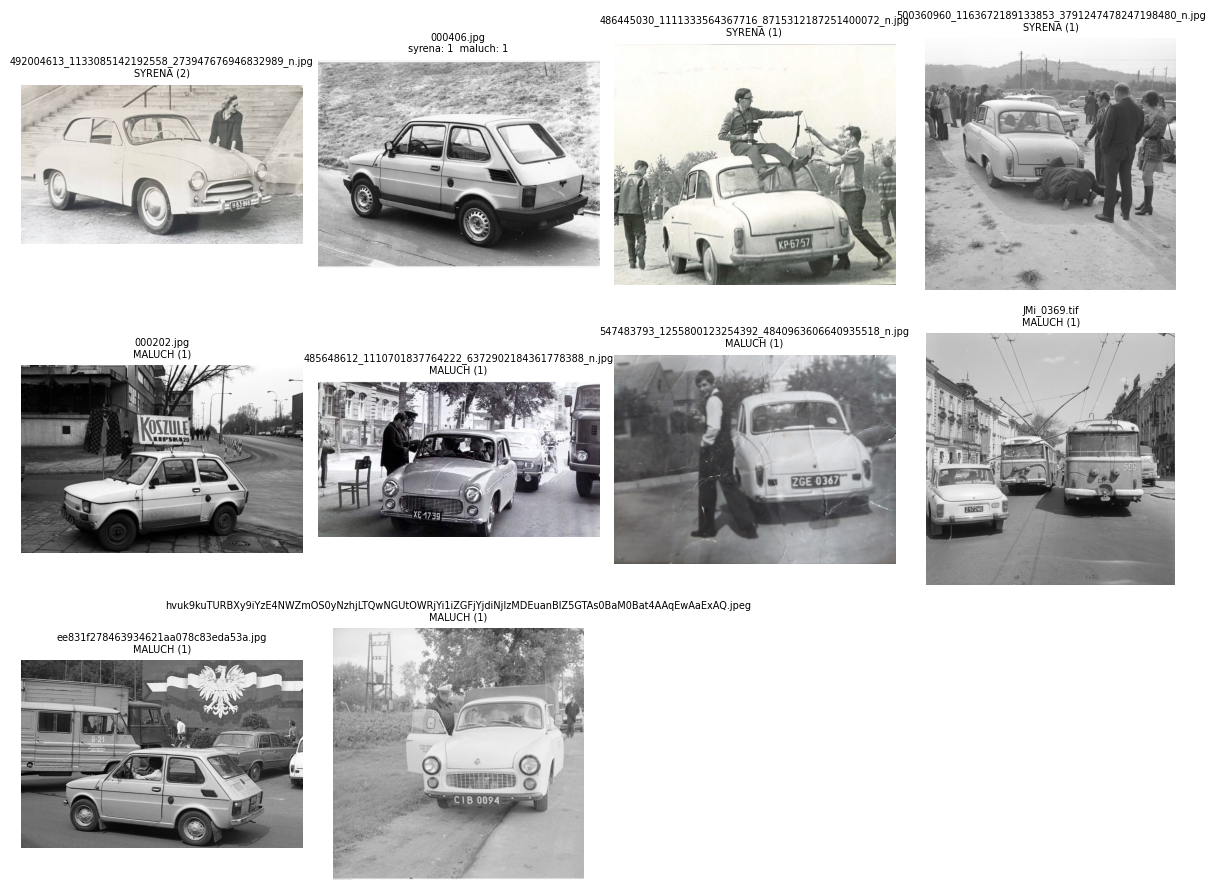

In [50]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import math

"""
    Miniatury Syren i Maluchów posortowane wg liczby detekcji.

    Podpis pod miniaturą:
    - jeśli tylko Syrena → "SYRENA (n)",
    - jeśli tylko Maluch → "MALUCH (n)",
    - jeśli obie klasy → "syrena: n  maluch: m",
    - jeśli brak detekcji → "brak detekcji".
"""

PROJECT_ROOT = Path.cwd().resolve()
IMAGES_DIR = PROJECT_ROOT / "inputs"

pivot = (
    df_det_filt
    .pivot_table(
        index="file_name",
        columns="class_norm",
        values="score",
        aggfunc="count",
        fill_value=0,
    )
    .reset_index()
)

pivot.columns.name = None
pivot = pivot.sort_values(["syrena", "maluch"], ascending=False)

top_n = 12
files = pivot["file_name"].head(top_n).tolist()

ncols = 4
nrows = math.ceil(len(files) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
axes = axes.flatten()

for ax, fname in zip(axes, files):
    img_path = IMAGES_DIR / fname
    if not img_path.exists():
        ax.axis("off")
        continue

    img = Image.open(img_path).convert("RGB")
    ax.imshow(img)
    ax.axis("off")

    row = pivot[pivot["file_name"] == fname].iloc[0]
    sy = int(row.get("syrena", 0))
    mal = int(row.get("maluch", 0))

    if sy > 0 and mal == 0:
        label = f"SYRENA ({sy})"
    elif mal > 0 and sy == 0:
        label = f"MALUCH ({mal})"
    elif sy > 0 and mal > 0:
        label = f"syrena: {sy}  maluch: {mal}"
    else:
        label = "brak detekcji"

    ax.set_title(f"{fname}\n{label}", fontsize=7)

for ax in axes[len(files):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [33]:
# filtr: tylko te detekcje, które mają zmapowane class_norm
df_det_filt = df_det[~df_det["class_norm"].isna()].copy()

print("Po filtrze:", len(df_det_filt))

from collections import Counter
print("Modele:", Counter(df_det_filt["model"]))
print("Klasy:", df_det_filt["class_norm"].value_counts())

Po filtrze: 12
Modele: Counter({'yolo_syrena_maluch': 12})
Klasy: class_norm
maluch    7
syrena    5
Name: count, dtype: int64


In [34]:
df_basic = compute_basic_counts(df_det_filt, df_gt)
df_basic.sort_values(["class_norm", "model"], inplace=True)
df_basic

,model,class_norm,n_det,n_images,n_gt
0,yolo_syrena_maluch,maluch,7,7,None
1,yolo_syrena_maluch,syrena,5,4,None


In [35]:
df_basic_sm = df_basic[df_basic["class_norm"].isin(["syrena", "maluch"])].copy()
df_basic_sm

,model,class_norm,n_det,n_images,n_gt
0,yolo_syrena_maluch,maluch,7,7,None
1,yolo_syrena_maluch,syrena,5,4,None


### 1. Wczytanie annotacji ground truth (opcjonalne)

In [36]:
GT_DIR = PROJECT_ROOT / "data" / "gt_annotations"
GT_CSV = GT_DIR / "gt_boxes.csv"

if GT_CSV.exists():
    df_gt = pd.read_csv(GT_CSV)
else:
    df_gt = pd.DataFrame(columns=["file_name", "class_norm", "x_min", "y_min", "x_max", "y_max"])

print("Liczba annotacji GT:", len(df_gt))
df_gt.head()

Liczba annotacji GT: 0


,file_name,class_norm,x_min,y_min,x_max,y_max


### 2. Przygotowanie danych do liczenia metryk

In [37]:
"""
W tym miejscu można:
- ujednolicić typy danych,
- odfiltrować detekcje o zbyt niskim score,
- zawęzić klasy do wybranego podzbioru.

Poniżej szkic filtracji po progu score.
"""

SCORE_THRESHOLD = 0.3

if not df_det.empty:
    df_det_filt = df_det[df_det["score"] >= SCORE_THRESHOLD].copy()
else:
    df_det_filt = df_det

print("Po filtracji score:", len(df_det_filt))

Po filtracji score: 11


### 3. Szkic funkcji do liczenia metryk per model i klasa

In [38]:
def compute_basic_counts(df_det: pd.DataFrame, df_gt: pd.DataFrame) -> pd.DataFrame:
    """
    Liczy proste statystyki per model i klasa_norm.

    Zwraca:
    - n_det      – liczba detekcji,
    - n_images   – liczba obrazów, w których dana klasa została wykryta,
    - (opcjonalnie) n_gt – liczba annotacji GT dla tej klasy.
    """
    if df_det.empty:
        return pd.DataFrame()

    group_cols = ["model", "class_norm"]
    agg = (
        df_det.groupby(group_cols)
        .agg(
            n_det=("file_name", "size"),
            n_images=("file_name", pd.Series.nunique),
        )
        .reset_index()
    )

    if not df_gt.empty:
        gt_counts = (
            df_gt.groupby("class_norm")
            .agg(n_gt=("file_name", "size"))
            .reset_index()
        )
        agg = agg.merge(gt_counts, on="class_norm", how="left")
    else:
        agg["n_gt"] = None

    return agg

### 4. Tabela porównawcza: liczba detekcji per model i klasa

In [39]:
df_basic = compute_basic_counts(df_det_filt, df_gt)
df_basic.sort_values(["class_norm", "model"], inplace=True)
df_basic

,model,class_norm,n_det,n_images,n_gt
0,yolo_syrena_maluch,maluch,6,6,None
1,yolo_syrena_maluch,syrena,5,4,None


### 5. (Opcjonalnie) szkic metryk IoU / precision / recalls

In [40]:
"""
Tutaj można dodać dokładniejsze metryki (IoU, precision, recall, mAP).
Szkielet funkcji zostawiam jako TODO, żebyś mogła zdecydować, jakie dokładnie metryki chcesz liczyć.
"""

def compute_detection_metrics(df_det: pd.DataFrame, df_gt: pd.DataFrame) -> pd.DataFrame:
    """
    Szkic funkcji do liczenia metryk detekcji na podstawie IoU.

    TODO:
    - dla każdego modelu i klasy:
      * dopasować detekcje do GT po IoU >= threshold,
      * policzyć TP, FP, FN,
      * wyliczyć precision, recall, F1, mAP.
    """
    # TODO: implementacja metryk
    return pd.DataFrame()

### 6. Podsumowanie benchmarku (do ręcznego uzupełnienia)

In [41]:
"""
W tej sekcji można:
- wyświetlić najważniejsze liczby,
- zapisać tabelę z wynikami do CSV,
- dopisać krótkie wnioski tekstowe (np. w komórce Markdown).

Na razie zapisujemy tylko df_basic.
"""

SUMMARY_CSV = EVAL_OUTPUT_DIR / "summary_basic_counts.csv"
df_basic.to_csv(SUMMARY_CSV, index=False)
print("Zapisano tabelę df_basic do:", SUMMARY_CSV.as_posix())

Zapisano tabelę df_basic do: /Users/olga/MetaLogic/outputs/detector_eval/summary_basic_counts.csv
